### Imports

In [39]:
import pandas as pd
import numpy as np
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk import tokenize
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

### Read the data

In [40]:
train = pd.read_csv('/Users/nikhilpatil/Downloads/train.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### Total Number of Null values

In [41]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

### Percentage of total null values

In [42]:
total = train.shape[0]
train.isnull().sum()/total*100

id        0.000000
title     2.682692
author    9.408654
text      0.187500
label     0.000000
dtype: float64

In [43]:
#As null values are less than 10 percent removing would be better for analysis
train.dropna(subset=['title', 'author'],inplace = True)

<AxesSubplot:xlabel='label'>

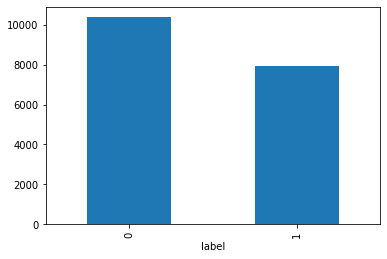

In [44]:
train.groupby(['label'])['text'].count().plot(kind="bar")

In [45]:
# Remaining data for model. There is slight imbalance which can be ignored as of now
train.groupby(['label']).count()['id']/train.shape[0]*100

label
0    56.663932
1    43.336068
Name: id, dtype: float64

### Remove punctuation 

In [73]:
def punctuation_removal(text):
    #print(text)
    all_list = [str(char) for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
#train['text'] = train['text'].apply(punctuation_removal)
#train['title'] = train['title'].apply(punctuation_removal)

### Removing Stop words

In [48]:
stop = stopwords.words('english')
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train['title'] = train['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

label
0    10361
1     7924
Name: text, dtype: int64


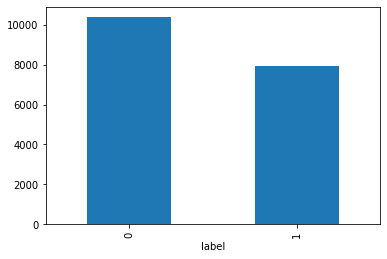

In [49]:
print(train.groupby(['label'])['text'].count())
train.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

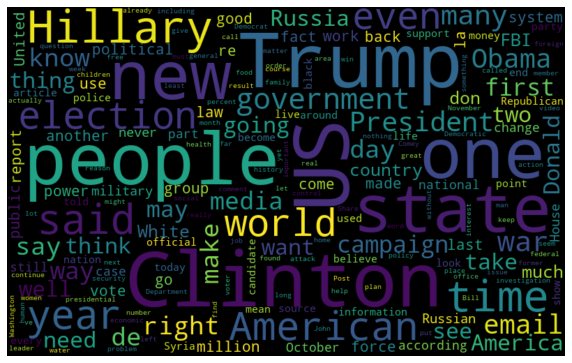

In [50]:
#Word cloud for fake news
fake_data = train[train["label"] == 1]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

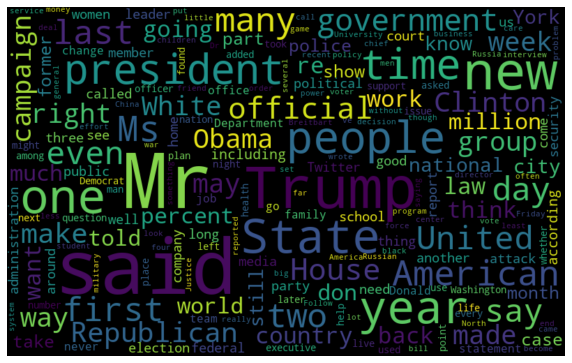

In [51]:
#Word cloud for real news
fake_data = train[train["label"] == 0]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [52]:
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

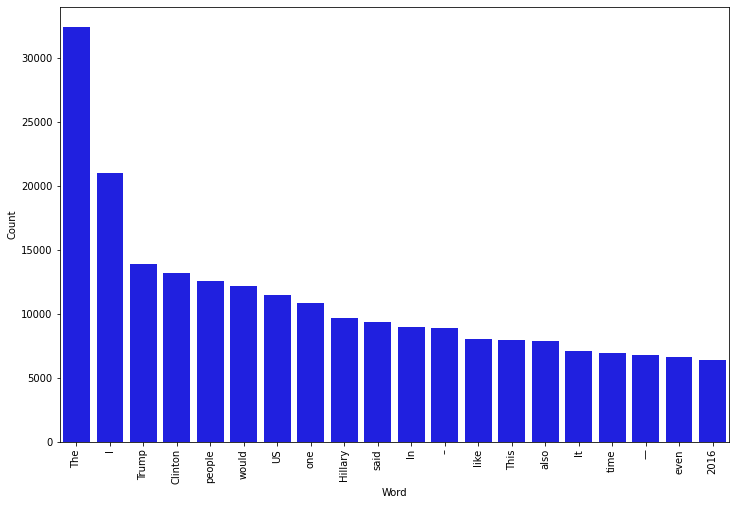

In [53]:
# Most frequent words counter in fake news
counter(train[train["label"] == 1], "text", 20)

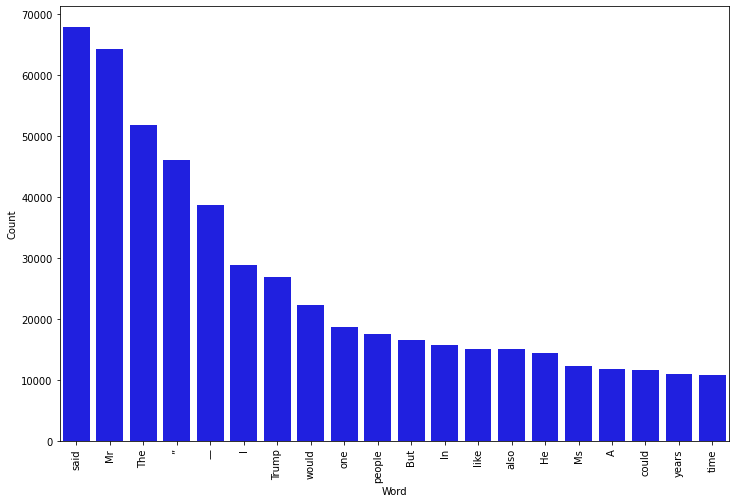

In [54]:
# Most frequent words counter in real news
counter(train[train["label"] == 0], "text", 20)

### Logistic Regression

#### Only Text Data

In [55]:
#Logistic Regression
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
X_train,X_test,y_train,y_test = train_test_split(train['text'], train.label, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
# Fitting the model
model = pipe.fit(X_train, y_train)
# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

(14628,)
(3657,)
accuracy: 94.86%


#### Only Title Data

In [56]:
X_title_train,X_title_test,y_title_train,y_title_test = train_test_split(train['title'], train.label, test_size=0.2, random_state=42)
# Fitting the model
model = pipe.fit(X_title_train, y_title_train)
# Accuracy
prediction = model.predict(X_title_test)
print("accuracy: {}%".format(round(accuracy_score(y_title_test, prediction)*100,2)))

accuracy: 91.71%


####  Concatenation of title and text

In [57]:
train['concate_title_text'] = train['title'] + " "+ train['text']
X_con_train,X_con_test,y_con_train,y_con_test = train_test_split(train['concate_title_text'], train.label, test_size=0.2, random_state=42)
# Fitting the model
model = pipe.fit(X_con_train, y_con_train)
final_model= model
# Accuracy
prediction = model.predict(X_con_test)
print("accuracy: {}%".format(round(accuracy_score(y_con_test, prediction)*100,2)))

accuracy: 95.57%


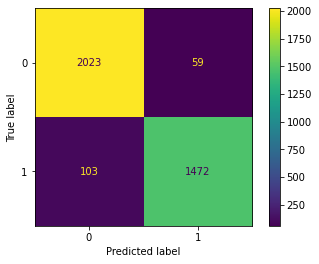

In [58]:
plot_confusion_matrix(model,X_con_test ,y_con_test)

In [59]:
print("Precision - "+str(precision_score(y_con_test,prediction)))
print("Recall - "+str(recall_score(y_con_test,prediction)))

Precision - 0.961463096015676
Recall - 0.9346031746031747


### Decision Tree

In [60]:
# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_con_train, y_con_train)
# Accuracy
prediction = model.predict(X_con_test)
print("accuracy: {}%".format(round(accuracy_score(y_con_test, prediction)*100,2)))

accuracy: 94.5%


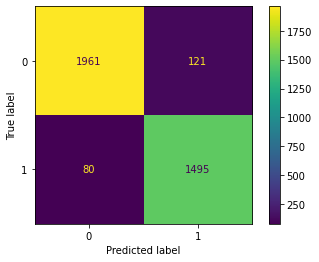

In [61]:
plot_confusion_matrix(model,X_con_test ,y_con_test )

In [62]:
print("Precision - "+str(precision_score(y_con_test,prediction)))
print("Recall - "+str(recall_score(y_con_test,prediction)))

Precision - 0.9251237623762376
Recall - 0.9492063492063492


### Running on test data

In [64]:
test = pd.read_csv('/Users/nikhilpatil/Downloads/fake-news/test.csv')

In [65]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [74]:
test.dropna(subset=['title', 'author'],inplace = True)
test['text'] = test['text'].apply(punctuation_removal)

In [75]:
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['title'] = test['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [76]:
test['concate_title_text'] = test['title'] + " "+ test['text']

In [78]:
test_prediction = final_model.predict(test['concate_title_text'])

In [79]:
test_prediction

array([0, 1, 0, ..., 0, 0, 0])

In [80]:
test['prediction'] = test_prediction

In [83]:
test[['id','prediction']].to_csv('submit.csv')